In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import matplotlib.lines as lines
import seaborn as sns
from scipy import stats as sci_stats
import matplotlib.gridspec as gridspec
colors = sns.color_palette('colorblind')

In [2]:
pl.rcParams['font.family'] = 'sans-serif'
pl.rcParams['font.sans-serif'] = 'Noto Sans'

In [3]:
vtn_s = pd.read_csv('../../output/VTn_s.csv')
byrm_s = pd.read_csv('../../output/BYxRM_s.csv')
vtn_x = pd.read_csv('../../output/VTn_x.csv')
byrm_x = pd.read_csv('../../output/BYxRM_x.csv')
vtn_s = vtn_s.merge(vtn_x[['Sample', 'Fitness', 'Fitness_sub_70']], on='Sample', how='left')
byrm_s = byrm_s.merge(byrm_x, on='Sample', how='left')
conditions = ['P1_YPD_30C', 'P3_SC_37C', 'P1_SC_37C']
vtn_s = vtn_s[vtn_s.Cond.isin(conditions)]
byrm_s = byrm_s[pd.notnull(byrm_s['s'])] # didn't have to do this for vtn_s bc it has no nulls
g70_fits = {i[0]: i[1] for i in np.array(vtn_x[vtn_x.Gen==70][['Cond', 'Fitness']].groupby('Cond').mean().reset_index()[['Cond', 'Fitness']])}

In [4]:
# Samples must have at least 20 mutations with s measurements in one condition to be included in DFE-level analyses:
svc = {cond: dict(vtn_s[vtn_s.Cond==cond].Sample.value_counts()) for cond in conditions}
vtn_s_for_dfe = vtn_s[vtn_s.apply(lambda r: svc[r['Cond']][r['Sample']]>=20, axis=1)]
byrm_svc = dict(byrm_s.Sample.value_counts())
# cutoff is 50 mutations for by x rm
byrm_s = byrm_s[byrm_s.Sample.apply(lambda s: byrm_svc[s]>=50)]

In [5]:
byrm_dfe = byrm_s[['Sample', 's']].groupby('Sample').mean().reset_index().rename(columns={'s': 'DFE_mean'})
byrm_dfe = byrm_dfe.merge(byrm_s[['Sample', 's']].groupby('Sample').std().reset_index().rename(columns={'s': 'DFE_std'}), on='Sample')
byrm_dfe = byrm_dfe.merge(byrm_s[['Sample', 's']].groupby('Sample').count().reset_index().rename(columns={'s': 's_count'}), on='Sample')
byrm_dfe = byrm_dfe.merge(byrm_x, on='Sample', how='left')
byrm_dfe.head(2)

,Sample,DFE_mean,DFE_std,s_count,Fitness
0,LK1-A02,-0.022128,0.024838,72,0.074569
1,LK1-A05,-0.028069,0.033583,72,0.071813


In [6]:
vtn_dfe = vtn_s_for_dfe[['Sample', 's']].groupby('Sample').mean().reset_index().rename(columns={'s': 'DFE_mean'})
vtn_dfe = vtn_dfe.merge(vtn_s[['Sample', 's']].groupby('Sample').std().reset_index().rename(columns={'s': 'DFE_std'}), on='Sample')
vtn_dfe = vtn_dfe.merge(vtn_s[['Sample', 's']].groupby('Sample').skew().reset_index().rename(columns={'s': 'DFE_skew'}), on='Sample')
vtn_x['Fitness_std'] = np.std(vtn_x[['Clone_A_s', 'Clone_B_s']], axis=1)
vtn_dfe = vtn_dfe.merge(vtn_x[['Sample', 'Fitness', 'Fitness_std']], on='Sample', how='left')
vtn_dfe['Pop'] = vtn_dfe['Sample'].str.split('_').str[1]
vtn_dfe['Env'] = vtn_dfe['Sample'].apply(lambda s: '_'.join(s.split('_')[2:]))
vtn_dfe['Cond'] = vtn_dfe['Pop'].str[:2]+'_'+vtn_dfe['Env']
vtn_dfe['Gen'] = vtn_dfe['Sample'].apply(lambda s: int(s.split('_')[0][1:]))
vtn_dfe['Gen_pop'] = 'G'+vtn_dfe['Gen'].apply(lambda g: str(g))+'_'+vtn_dfe['Pop']
vtn_dfe.head(2)

,Sample,DFE_mean,DFE_std,DFE_skew,Fitness,Fitness_std,Pop,Env,Cond,Gen,Gen_pop
0,G10150_P1B04_SC_37C,-0.071181,0.087681,-1.552533,-0.153673,0.010828,P1B04,SC_37C,P1_SC_37C,10150,G10150_P1B04
1,G10150_P1B04_YPD_30C,-0.047015,0.047733,-1.215712,0.021696,0.008507,P1B04,YPD_30C,P1_YPD_30C,10150,G10150_P1B04


In [7]:
p1_pops = ['P1B04','P1C04','P1C05','P1D03','P1F05','P1G04']
p3_pops = ['P3C03','P3D03','P3F03','P3G02','P3G05','P3G06']
cond_pops = {'P1': p1_pops, 'P3': p3_pops}
color_map = {p1_pops[i]:colors[i] for i in range(len(p1_pops))}
color_map.update({p3_pops[i]:colors[i] for i in range(len(p3_pops))})
cond_to_title = {'P1_YPD_30C': 'YPD 30°C', 'P3_SC_37C': 'SC 37°C', 'P1_SC_37C': 'Evo. YPD 30°C, in SC 37°C',
                 'P3_bad_SC_37C': 'Evo. SC 37°C, in bad media'}

P1_YPD_30C P1B04 0.009573972934673419
P1_YPD_30C P1C04 0.013990146557787414
P1_YPD_30C P1C05 0.2853443563273157
P1_YPD_30C P1D03 0.05376709819118781
P1_YPD_30C P1F05 0.013916943736936045
P1_YPD_30C P1G04 0.02004800751691889
P1_YPD_30C All, Gen 1.9927335101475063e-06
P1_YPD_30C All, Fitness 3.642288224746397e-06
P3_SC_37C P3C03 0.09496012292553441
P3_SC_37C P3D03 0.07550947355980886
P3_SC_37C P3F03 0.18777313023554715
P3_SC_37C P3G02 0.16379300620830714
P3_SC_37C P3G05 0.7567619422002181
P3_SC_37C P3G06 0.2198677142410309
P3_SC_37C All, Gen 0.1256016311349785
P3_SC_37C All, Fitness 0.18427843948075132


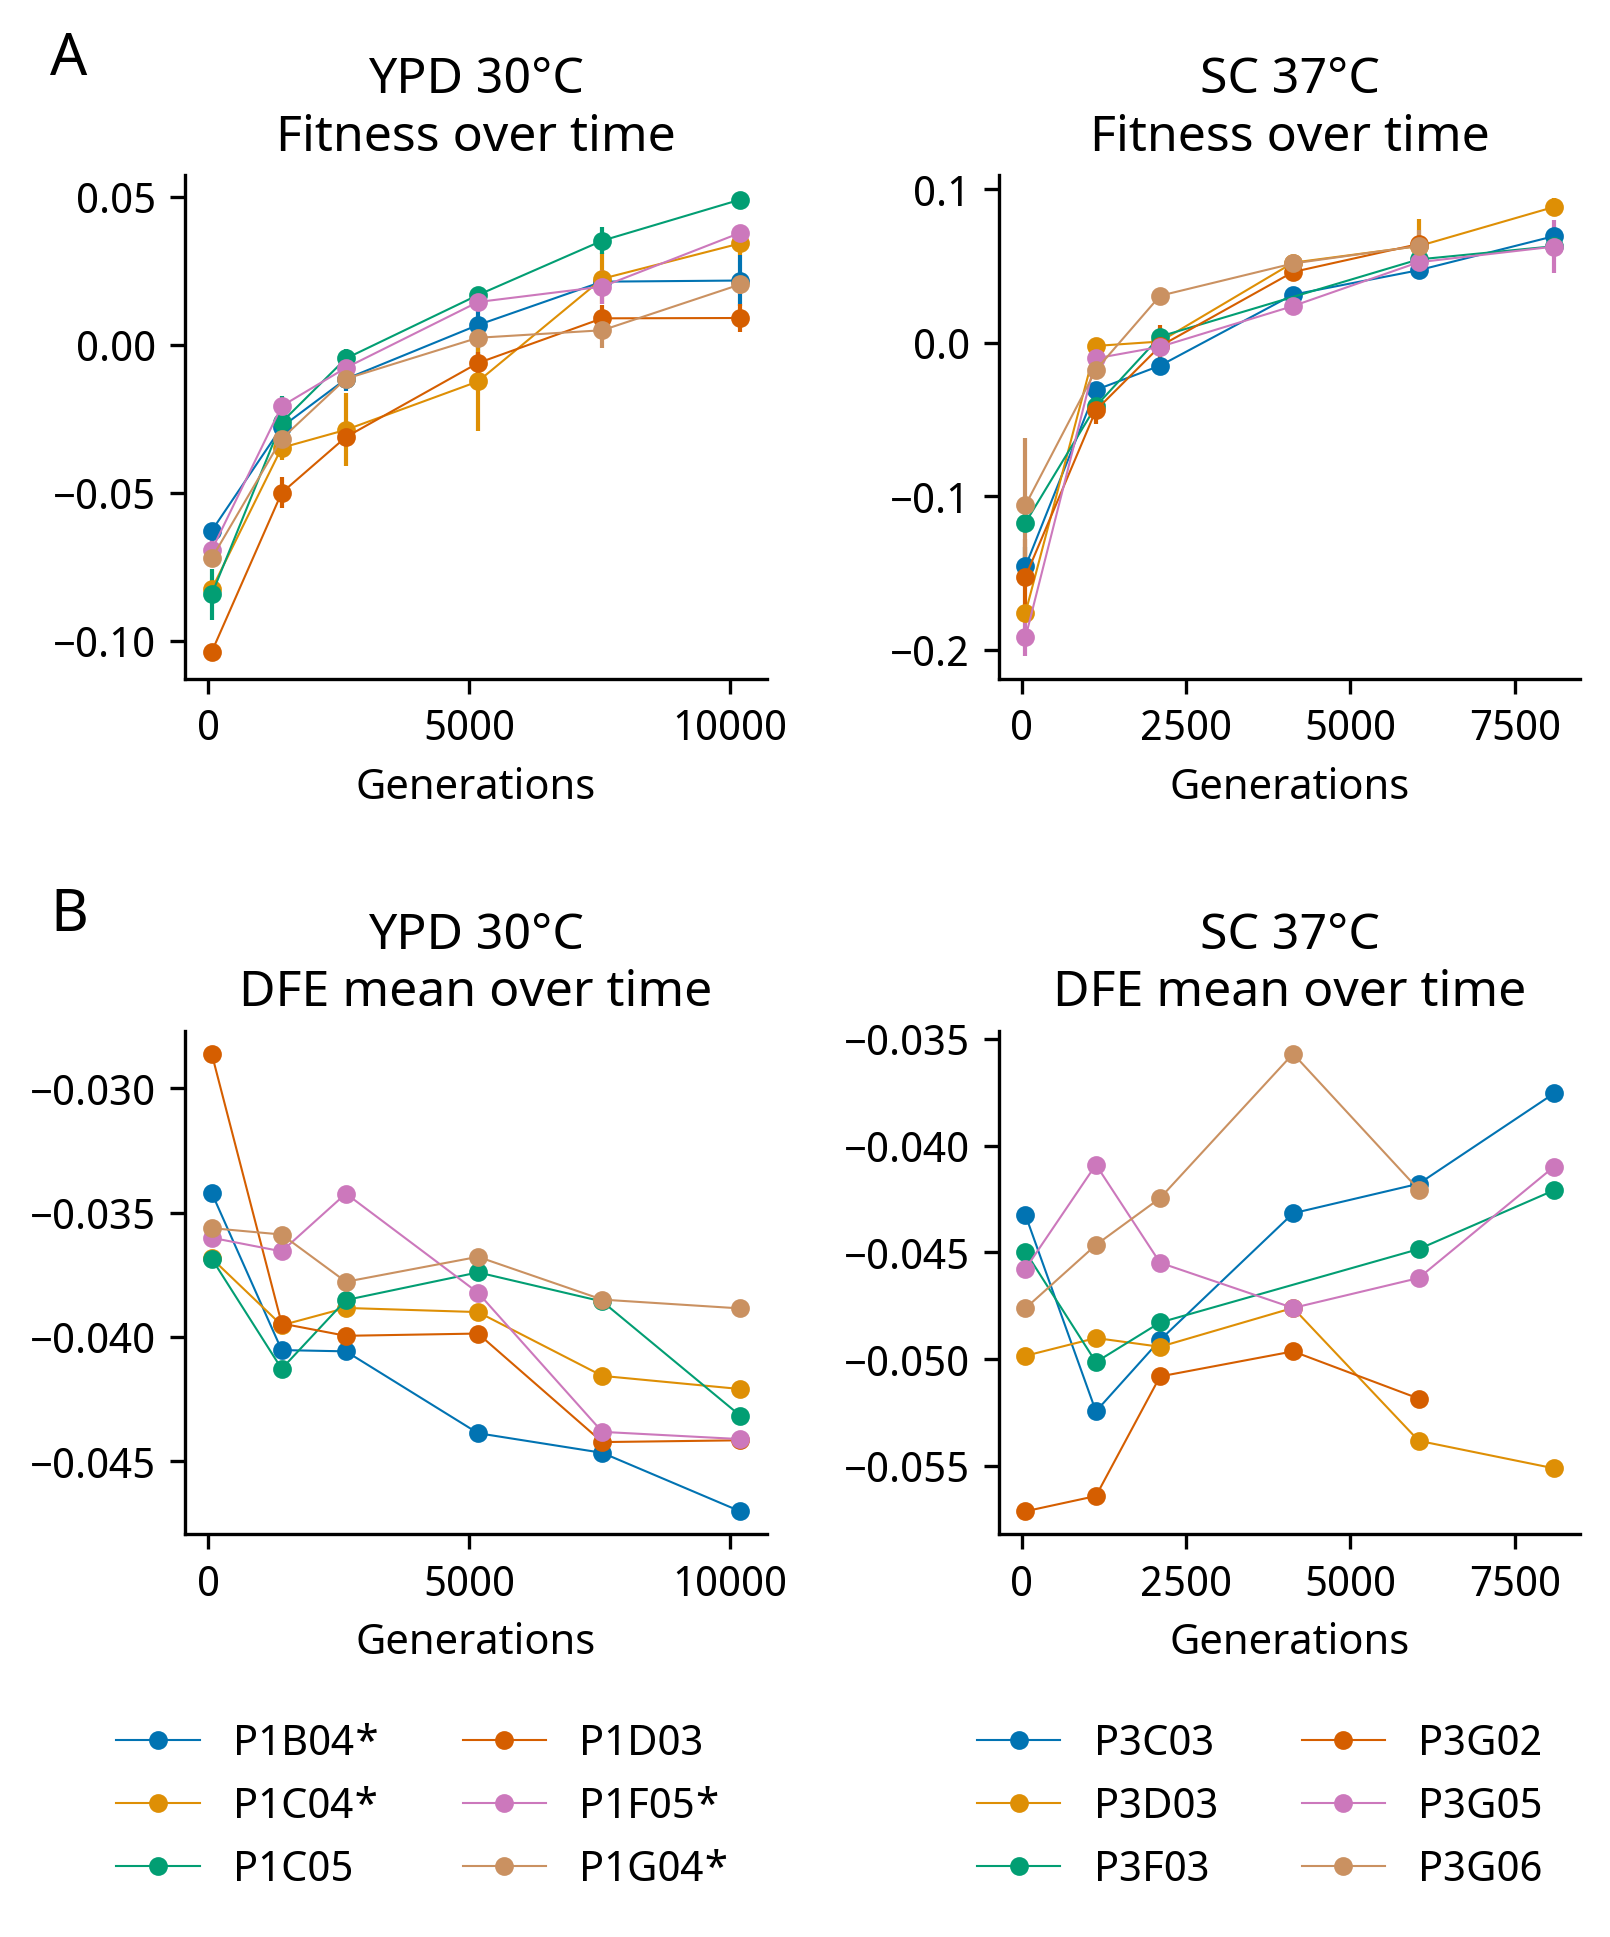

In [8]:
# This dictionary changes the recorded generation numbers to the correct generation numbers
# Since P3 only does 8 gens/day it is very different, the other differences are due to little recording errors
gen_fixer = {70: {'P1': 70, 'P2': 70, 'P3': 56, 'P4': 70},
             550: {'P1': 560, 'P2': 560, 'P3': 448, 'P4': 560},
             1410: {'P1': 1410, 'P2': 1410, 'P3': 1128, 'P4': 1410},
             2640: {'P1': 2640, 'P2': 2640, 'P3': 2104, 'P4': 2640},
             3630: {'P1': 3660, 'P2': 3660, 'P3': 2920, 'P4': 3660},
             5150: {'P1': 5170, 'P2': 5170, 'P3': 4128, 'P4': 5170},
             7530: {'P1': 7550, 'P2': 7560, 'P3': 6040, 'P4': 7560},
             10150: {'P1': 10190, 'P2': 10200, 'P3': 8096, 'P4': 10200}}

fig, subps = pl.subplots(2, 2, figsize=(6,6), dpi=300)
pl.subplots_adjust(wspace=0.4, hspace=0.7)
for i in range(2):
    cond = conditions[i]
    td = vtn_dfe[vtn_dfe.Cond==cond]
    for pop in cond_pops[cond.split('_')[0]]:
        ttd = td[td.Pop==pop].sort_values('Gen')
        gen_rec = [gen_fixer[g][cond.split('_')[0]] for g in ttd['Gen']]
        if sci_stats.linregress(gen_rec, ttd['DFE_mean'])[3]<0.05:
            lab = pop+'*'
        else:
            lab = pop
        if len(ttd[ttd['Fitness_std']==0]) > 0:
            print('Missing errors for', cond, pop, list(ttd[ttd['Fitness_std']==0]['Gen']))
        subps[1][i].plot(gen_rec, ttd['DFE_mean'], linestyle='-', marker='.', markersize=7, linewidth=0.5, color=color_map[pop], label=lab)
        subps[0][i].errorbar(x=gen_rec, y=ttd['Fitness'], yerr=ttd['Fitness_std'], linestyle='-', marker='.', markersize=7, elinewidth=1, linewidth=0.5, color=color_map[pop], label=pop)
        print(cond, pop, sci_stats.linregress(ttd['Gen'], ttd['DFE_mean'])[3])
    print(cond, 'All, Gen', sci_stats.linregress(td['Gen'], td['DFE_mean'])[3])
    print(cond, 'All, Fitness', sci_stats.linregress(td['Fitness'], td['DFE_mean'])[3])
    subps[0][i].set_title(cond_to_title[cond]+'\nFitness over time')
    subps[1][i].set_title(cond_to_title[cond]+'\nDFE mean over time')
    subps[0][i].set_xlabel('Generations')
    subps[1][i].set_xlabel('Generations')
    subps[1][i].legend(frameon=False, bbox_to_anchor=(1, -0.3), ncol=2)

#subps[0][0].set_ylabel('Fitness')
#subps[1][0].set_ylabel('DFE mean')
subps[0][0].annotate('A', fontsize=14, xy=(-0.2, 1.2), xycoords="axes fraction", horizontalalignment="center")
subps[1][0].annotate('B', fontsize=14, xy=(-0.2, 1.2), xycoords="axes fraction", horizontalalignment="center")

sns.despine()
fig.savefig('../../Figures/DFEs.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)

In [9]:
edge_stats = pd.read_csv('data_by_mutation.csv')

In [10]:
for cond in conditions[:2]:
    td = edge_stats[(pd.notnull(edge_stats[cond+'_call'])) & (edge_stats.Type=='Experiment')]
    print('In', cond, 'out of', len(td), 'mutations,', len(td[td[cond+'_call']=='-']), 'have neg slopes and', len(td[td[cond+'_call']=='+']), 'have pos slopes.')
print('Overlap:', len(edge_stats[(pd.notnull(edge_stats['P1_YPD_30C_call'])) & (pd.notnull(edge_stats['P3_SC_37C_call'])) & (edge_stats.Type=='Experiment')]))

In P1_YPD_30C out of 77 mutations, 33 have neg slopes and 9 have pos slopes.
In P3_SC_37C out of 74 mutations, 17 have neg slopes and 13 have pos slopes.
Overlap: 70


In [11]:
def plot_one(sub, cond, edge, axis_color, xvar='Fitness', lw=0.5):
    td = vtn_s[(vtn_s['Edge']==edge) & (vtn_s['Cond']==cond) & (vtn_s['num_cbcs']>=5)]
    sub.axhline(0, linestyle='dashed', color='k', linewidth=lw/2, alpha=0.6)
    for pop in cond_pops[cond.split('_')[0]]:
        ttd = td[td.Pop==pop].sort_values('Gen')
        ls = ''
        if xvar == 'Gen': ls = '-'
        sub.errorbar(x=ttd[xvar], y=ttd['s'], yerr=ttd['stderr'], linestyle=ls, marker='.', markersize=2, linewidth=lw, color=color_map[pop], label=pop)
    #sub.set_ylim([-0.15, 0.1])
    sub.tick_params(which='both', labelsize=6, colors=axis_color)
    sub.spines['bottom'].set_color(axis_color)
    sub.spines['left'].set_color(axis_color)
    
    
def plot_one_byrm(sub, edge, axis_color):
    ttd = byrm_s[(byrm_s['Edge']==edge) & (byrm_s['num_cbcs']>=5)]
    sub.axhline(0, linestyle='dashed', color='k', linewidth=0.25, alpha=0.6)
    sub.errorbar(x=ttd['Fitness'], y=ttd['s'], yerr=ttd['stderr'], linestyle='', marker='.', markersize=1, linewidth=0.5, color='k')
    #sub.set_ylim([-0.15, 0.1])
    sub.tick_params(which='both', labelsize=6, colors=axis_color)
    sub.spines['bottom'].set_color(axis_color)
    sub.spines['left'].set_color(axis_color)
    
def tiny_plot(sub, yvals, axis_color, xlab='Fitness'):
    sub.plot([0,1], yvals, c=axis_color)
    sub.set_xticks([])
    sub.set_yticks([])
    sub.set_ylim([-2,2])
    sub.set_ylabel('s', color=axis_color, rotation='horizontal', fontsize=10, verticalalignment='center', y=0.49, labelpad=6)
    sub.set_xlabel(xlab, color=axis_color, rotation='horizontal', fontsize=8)
    sub.spines['bottom'].set_color(axis_color)
    sub.spines['left'].set_color(axis_color)
    sns.despine(ax=sub)

- - ['in NOP16', 'in RPL16A', 'in OCA1', 'in FLC2', 'in MPC2', 'in RPL31B', 'nearby NCP1', 'nearby CCW12', 'nearby VMA7', 'in RPL2A', 'in RPL35B', 'in UBP3', 'nearby KRE6', 'in RPL31B', 'in SPT8']
1
- NS ['nearby OST4', 'in LAT1', 'in FUN30', 'in PHO4', 'in GPP1', 'in HOS4', 'nearby MET4', 'in MAC1', 'in SCJ1', 'in STE24', 'in SLX5', 'nearby YLR264C-A', 'in RSC30']
1
NS - ['nearby RPL16A', 'in ADE5,7']
1
NS NS ['in CPR6', 'in MME1', 'in FUN30', 'nearby SFP1', 'nearby NUP157', 'in TRM9', 'in SIR4', 'in PPM1', 'in SLX8', 'in KAP123', 'in EBS1', 'in TRP2', 'in OXA1', 'in VAM6', 'nearby PDE2', 'in UBP1', 'in TRP2', 'nearby UTP22', 'in CSR1', 'in CBS1', 'in VPS36', 'nearby PAH1', 'in RPS14B', 'in SIR4']
1
NS + ['in COG8', 'in SLX8', 'in RGS2', 'in SSK1', 'in SIR3', 'nearby YOL085W-A', 'nearby SRB2']
1
+ NS ['in BUL1', 'nearby KRI1', 'in VPS38', 'in STM1']
1
+ + ['in EAF1', 'in DPB4', 'in SUM1', 'in MCK1', 'in NOT3']
1


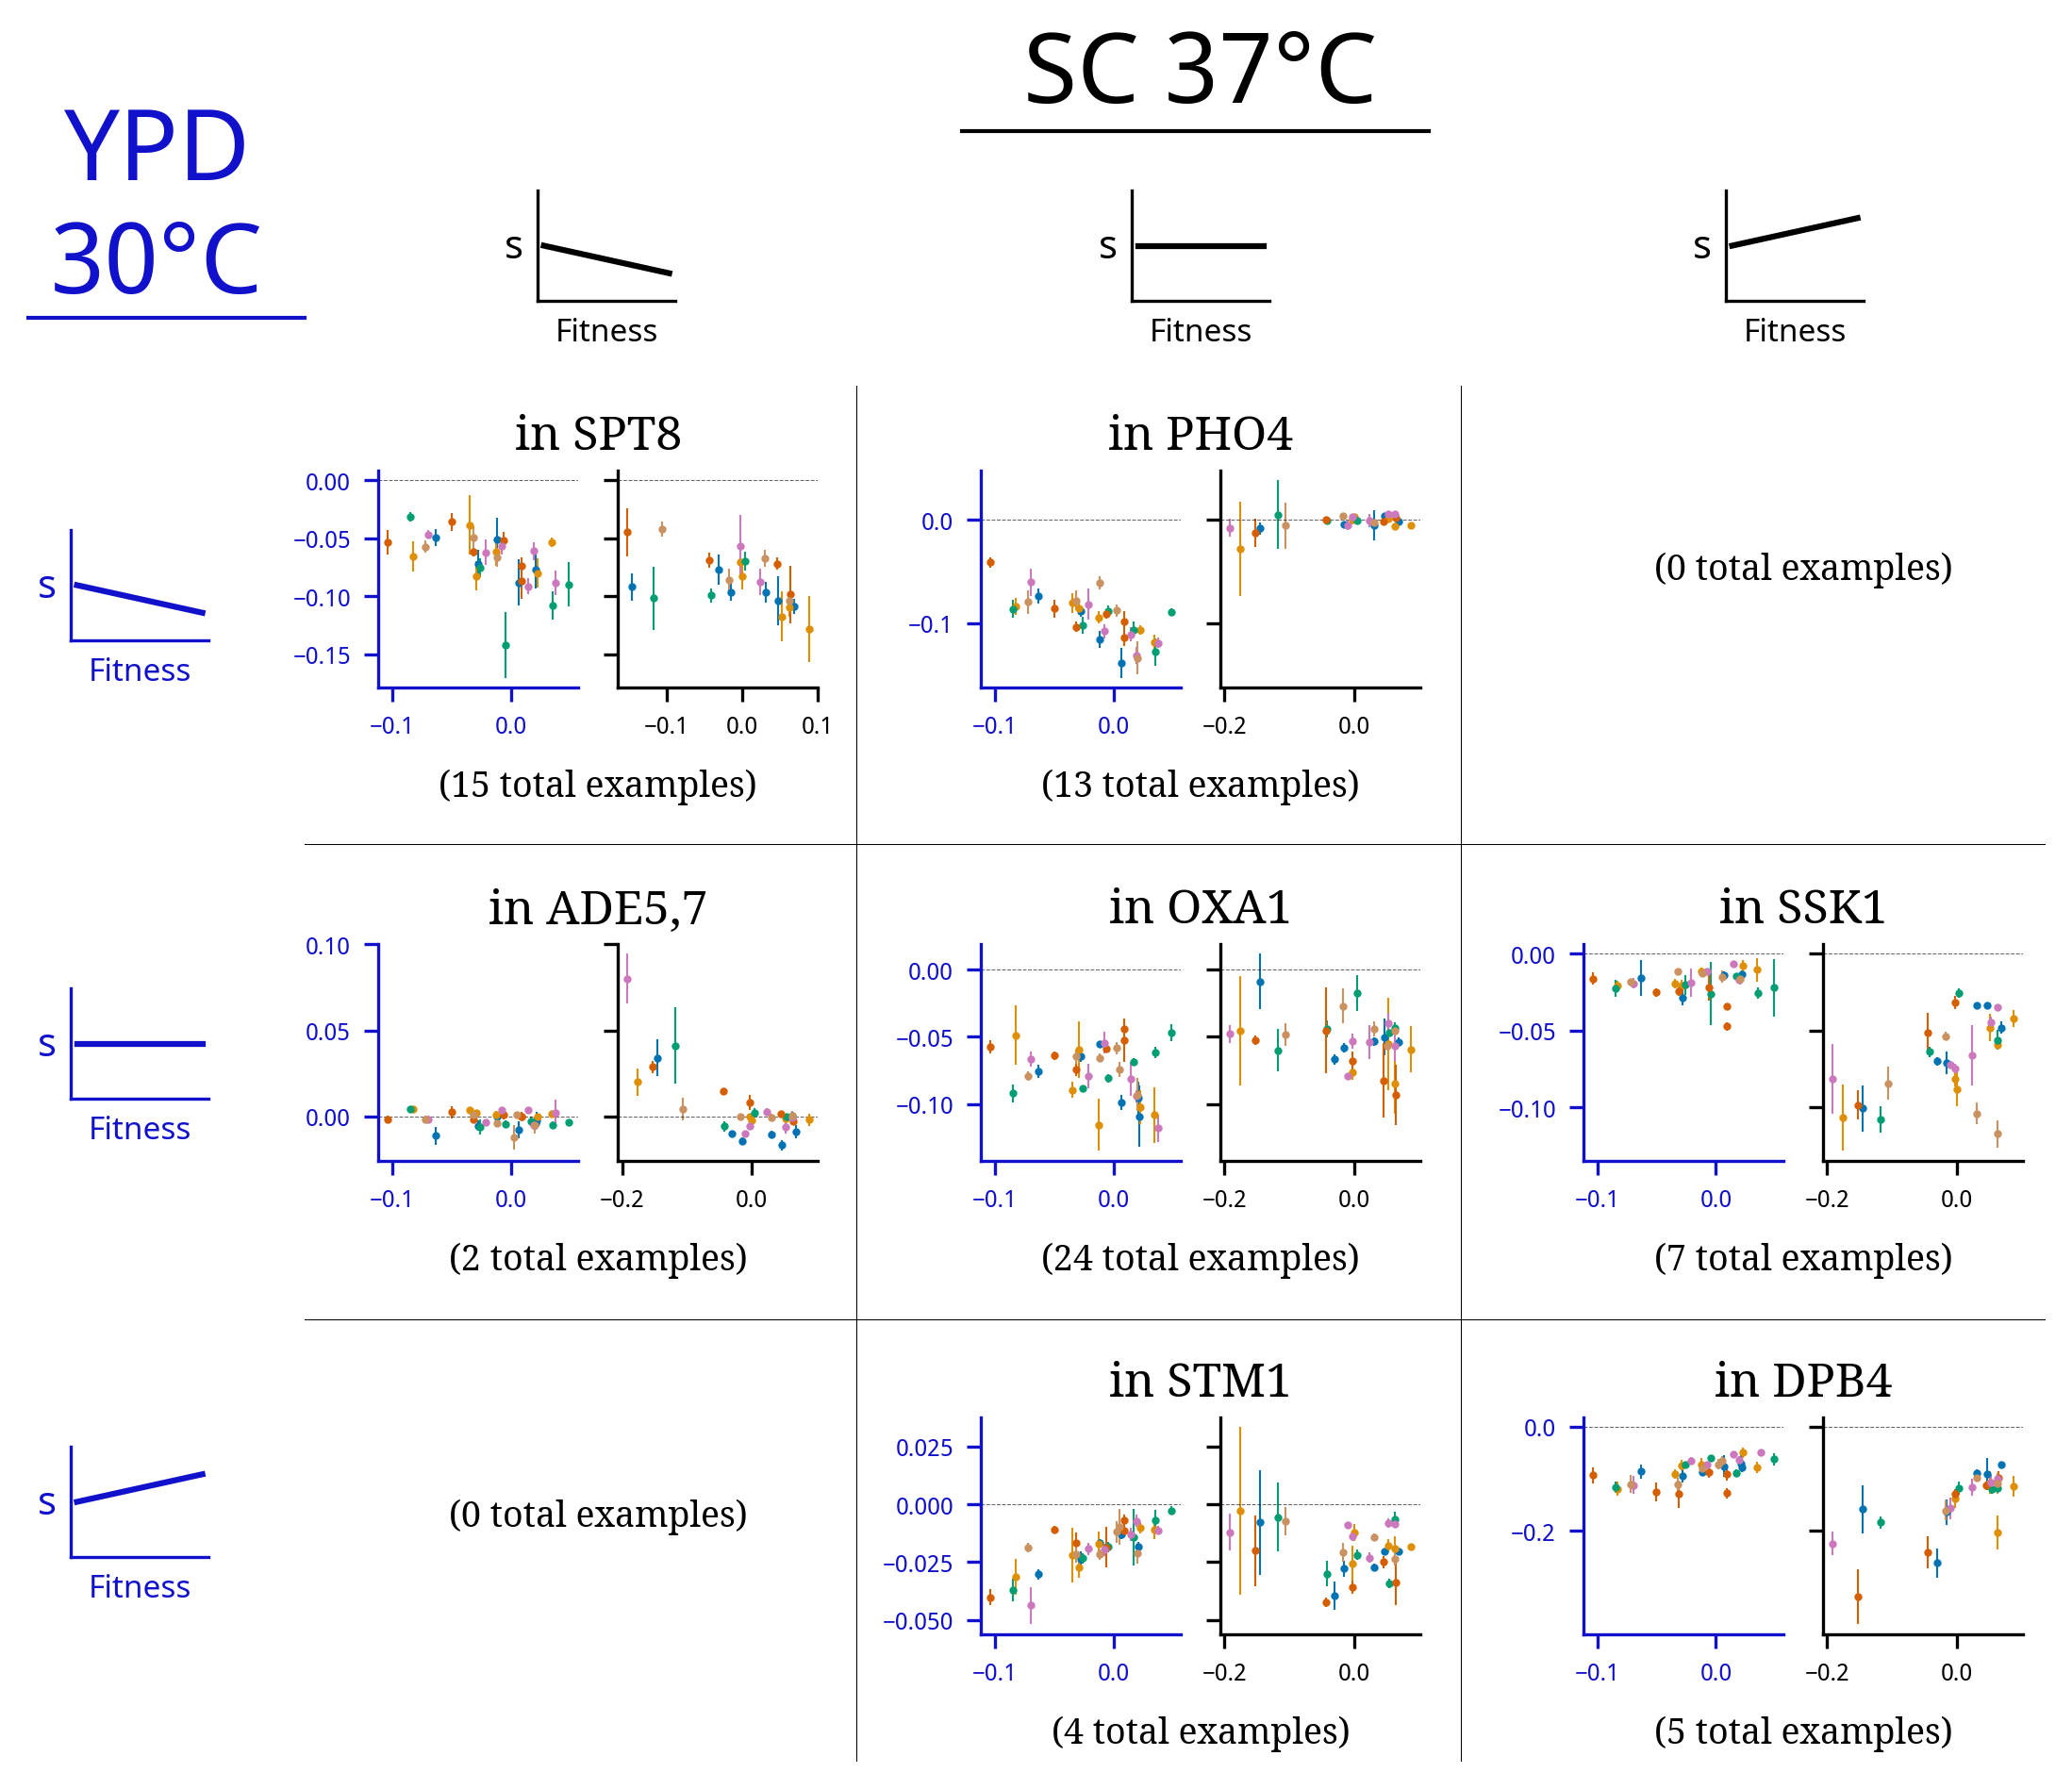

In [12]:
def cross_plot(c1, c2, color1, color2, n1, n2, examples, outname, xvar='Fitness', mod=''):
    calls = ['-', 'NS', '+']
    fig = pl.figure(figsize=(7.5, 6), dpi=300)
    gs0 = gridspec.GridSpec(11, 22)
    for i in range(3):
        for j in range(3):
            tmp_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[i*4:i*4+2,j*8:j*8+6])
            subs = [pl.Subplot(fig, tmp_gs[0])]
            subs.append(pl.Subplot(fig, tmp_gs[1], sharey=subs[0]))
            jnk = [fig.add_subplot(s) for s in subs] 
            pl.subplots_adjust(wspace=0.2)
            call1 = calls[i]
            call2 = calls[j]
            td = edge_stats[(edge_stats.Type=='Experiment') & (edge_stats[c1+mod+'_call']==call1) & (edge_stats[c2+mod+'_call']==call2)]
            if len(td) > 0:
                print(call1, call2, list(td['Gene_Use']))
                plot_one(subs[0], c1, examples[call1+'_'+call2], color1, xvar=xvar)
                if c2 == 'BYxRM':
                    plot_one_byrm(subs[1], examples[call1+'_'+call2], color2)
                else:
                    plot_one(subs[1], c2, examples[call1+'_'+call2], color2, xvar=xvar)
                print(len(td[td['Edge']==examples[call1+'_'+call2]]))
                if len(td[td['Edge']==examples[call1+'_'+call2]]) > 0:
                    subs[0].annotate(td[td['Edge']==examples[call1+'_'+call2]]['Gene_Use'].iloc[0], xy=(1.1,1.1), xycoords='axes fraction', fontfamily='Noto serif', fontsize=12, horizontalalignment='center')
                sns.despine(ax=subs[0])
                sns.despine(ax=subs[1])
                subs[0].annotate('('+str(len(td)) + ' total examples)', xy=(1.1,-0.5), xycoords='axes fraction', fontfamily='Noto serif', fontsize=9, horizontalalignment='center')
            else:
                subs[0].set_xticks([])
                subs[0].set_yticks([])
                sns.despine(ax=subs[0], left=True, bottom=True)
                subs[1].remove()
                subs[0].annotate('('+str(len(td)) + ' total examples)', xy=(1.1,0.5), xycoords='axes fraction', fontfamily='Noto serif', fontsize=9, horizontalalignment='center')

            #subs[1].set_yticks([])
            if i == 0:
                #subs[0].annotate(calls[j], xy=(1.1,2.2), xycoords='axes fraction', fontsize=25, horizontalalignment='center', color=color2)
                ax = fig.add_axes([0.2+j*0.28, 0.98, 0.065, 0.065])
                tiny_plot(ax, [0,j-1], color2)
                if j == 0:
                    subs[0].annotate(n1.replace(' ', '\n'), xy=(-1.11,2.2), xycoords='axes fraction', fontsize=25, horizontalalignment='center', verticalalignment='center', color=color1)
                if j == 1:
                    subs[0].annotate(n2, xy=(1.1,2.7), xycoords='axes fraction', fontsize=25, horizontalalignment='center', color=color2)
            if j == 0:
                #subs[0].annotate(calls[i], xy=(-1.1,0.6), xycoords='axes fraction', fontsize=25, horizontalalignment='center', verticalalignment='center', color=color1)
                ax = fig.add_axes([-0.02, 0.24+(2-i)*0.27, 0.065, 0.065])
                tiny_plot(ax, [0,i-1], color1)
            pl.setp(subs[1].get_yticklabels(), visible=False)

    shift = -0.05
    fig.add_artist(lines.Line2D([0.09, 0.91], [0.43+shift, 0.43+shift], c='k', linewidth=0.25))
    fig.add_artist(lines.Line2D([0.09, 0.91], [0.71+shift, 0.71+shift], c='k', linewidth=0.25))
    fig.add_artist(lines.Line2D([0.35, 0.35], [0.17+shift, 0.98+shift], c='k', linewidth=0.25))
    fig.add_artist(lines.Line2D([0.635, 0.635], [0.17+shift, 0.98+shift], c='k', linewidth=0.25))
    fig.add_artist(lines.Line2D([0.4, 0.62], [1.08, 1.08], c=color2, linewidth=1))
    fig.add_artist(lines.Line2D([-0.04, 0.09], [0.97, 0.97], c=color1, linewidth=1))
    fig.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)

calls = ['-', 'NS', '+']
examples = {
    calls[0]+'_'+calls[0]: 'CAATTTCAACGTTGT', # in SPT8
    calls[0]+'_'+calls[1]: 'CAAGTTCGGCGAAAT', # in_PHO4
    calls[0]+'_'+calls[2]: 'TCTTGGAGGTGAATG', # in STE24
    calls[1]+'_'+calls[0]: 'AGATTCATCCCATGG', # in ADE5,7
    calls[1]+'_'+calls[1]: 'ATCGTTGGCATTTGG', # in OXA1
    calls[1]+'_'+calls[2]: 'CCAGGATGTACCGCC', # in SSK1
    calls[2]+'_'+calls[1]: 'GTTGAACTGGTTGTT', # in STM1
    calls[2]+'_'+calls[2]: 'AGAACATCATCTACA'  # in DPB4
}

cross_plot('P1_YPD_30C', 'P3_SC_37C', '#11C', 'k', 'YPD 30°C', 'SC 37°C', examples, '../../Figures/Fitness_mediated_ep.pdf')

77 edges


/n/home13/mjohnson/anaconda3/envs/milo_py37/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/n/home13/mjohnson/anaconda3/envs/milo_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


YPD
-0.10448014617941266 0.07028897835816353
IM 218 coeffs, mean -0.017385738482704825  std dev: 0.027893017864348585
FM 140 coeffs, mean -0.011658908801464477  std dev: 0.027263344249044044
73 edges
SC
-0.24865240742142342 0.13920962735583658
IM 182 coeffs, mean 0.004872649971101678  std dev: 0.05282332959741453
FM 88 coeffs, mean -0.017874260166303557  std dev: 0.05030513301787589


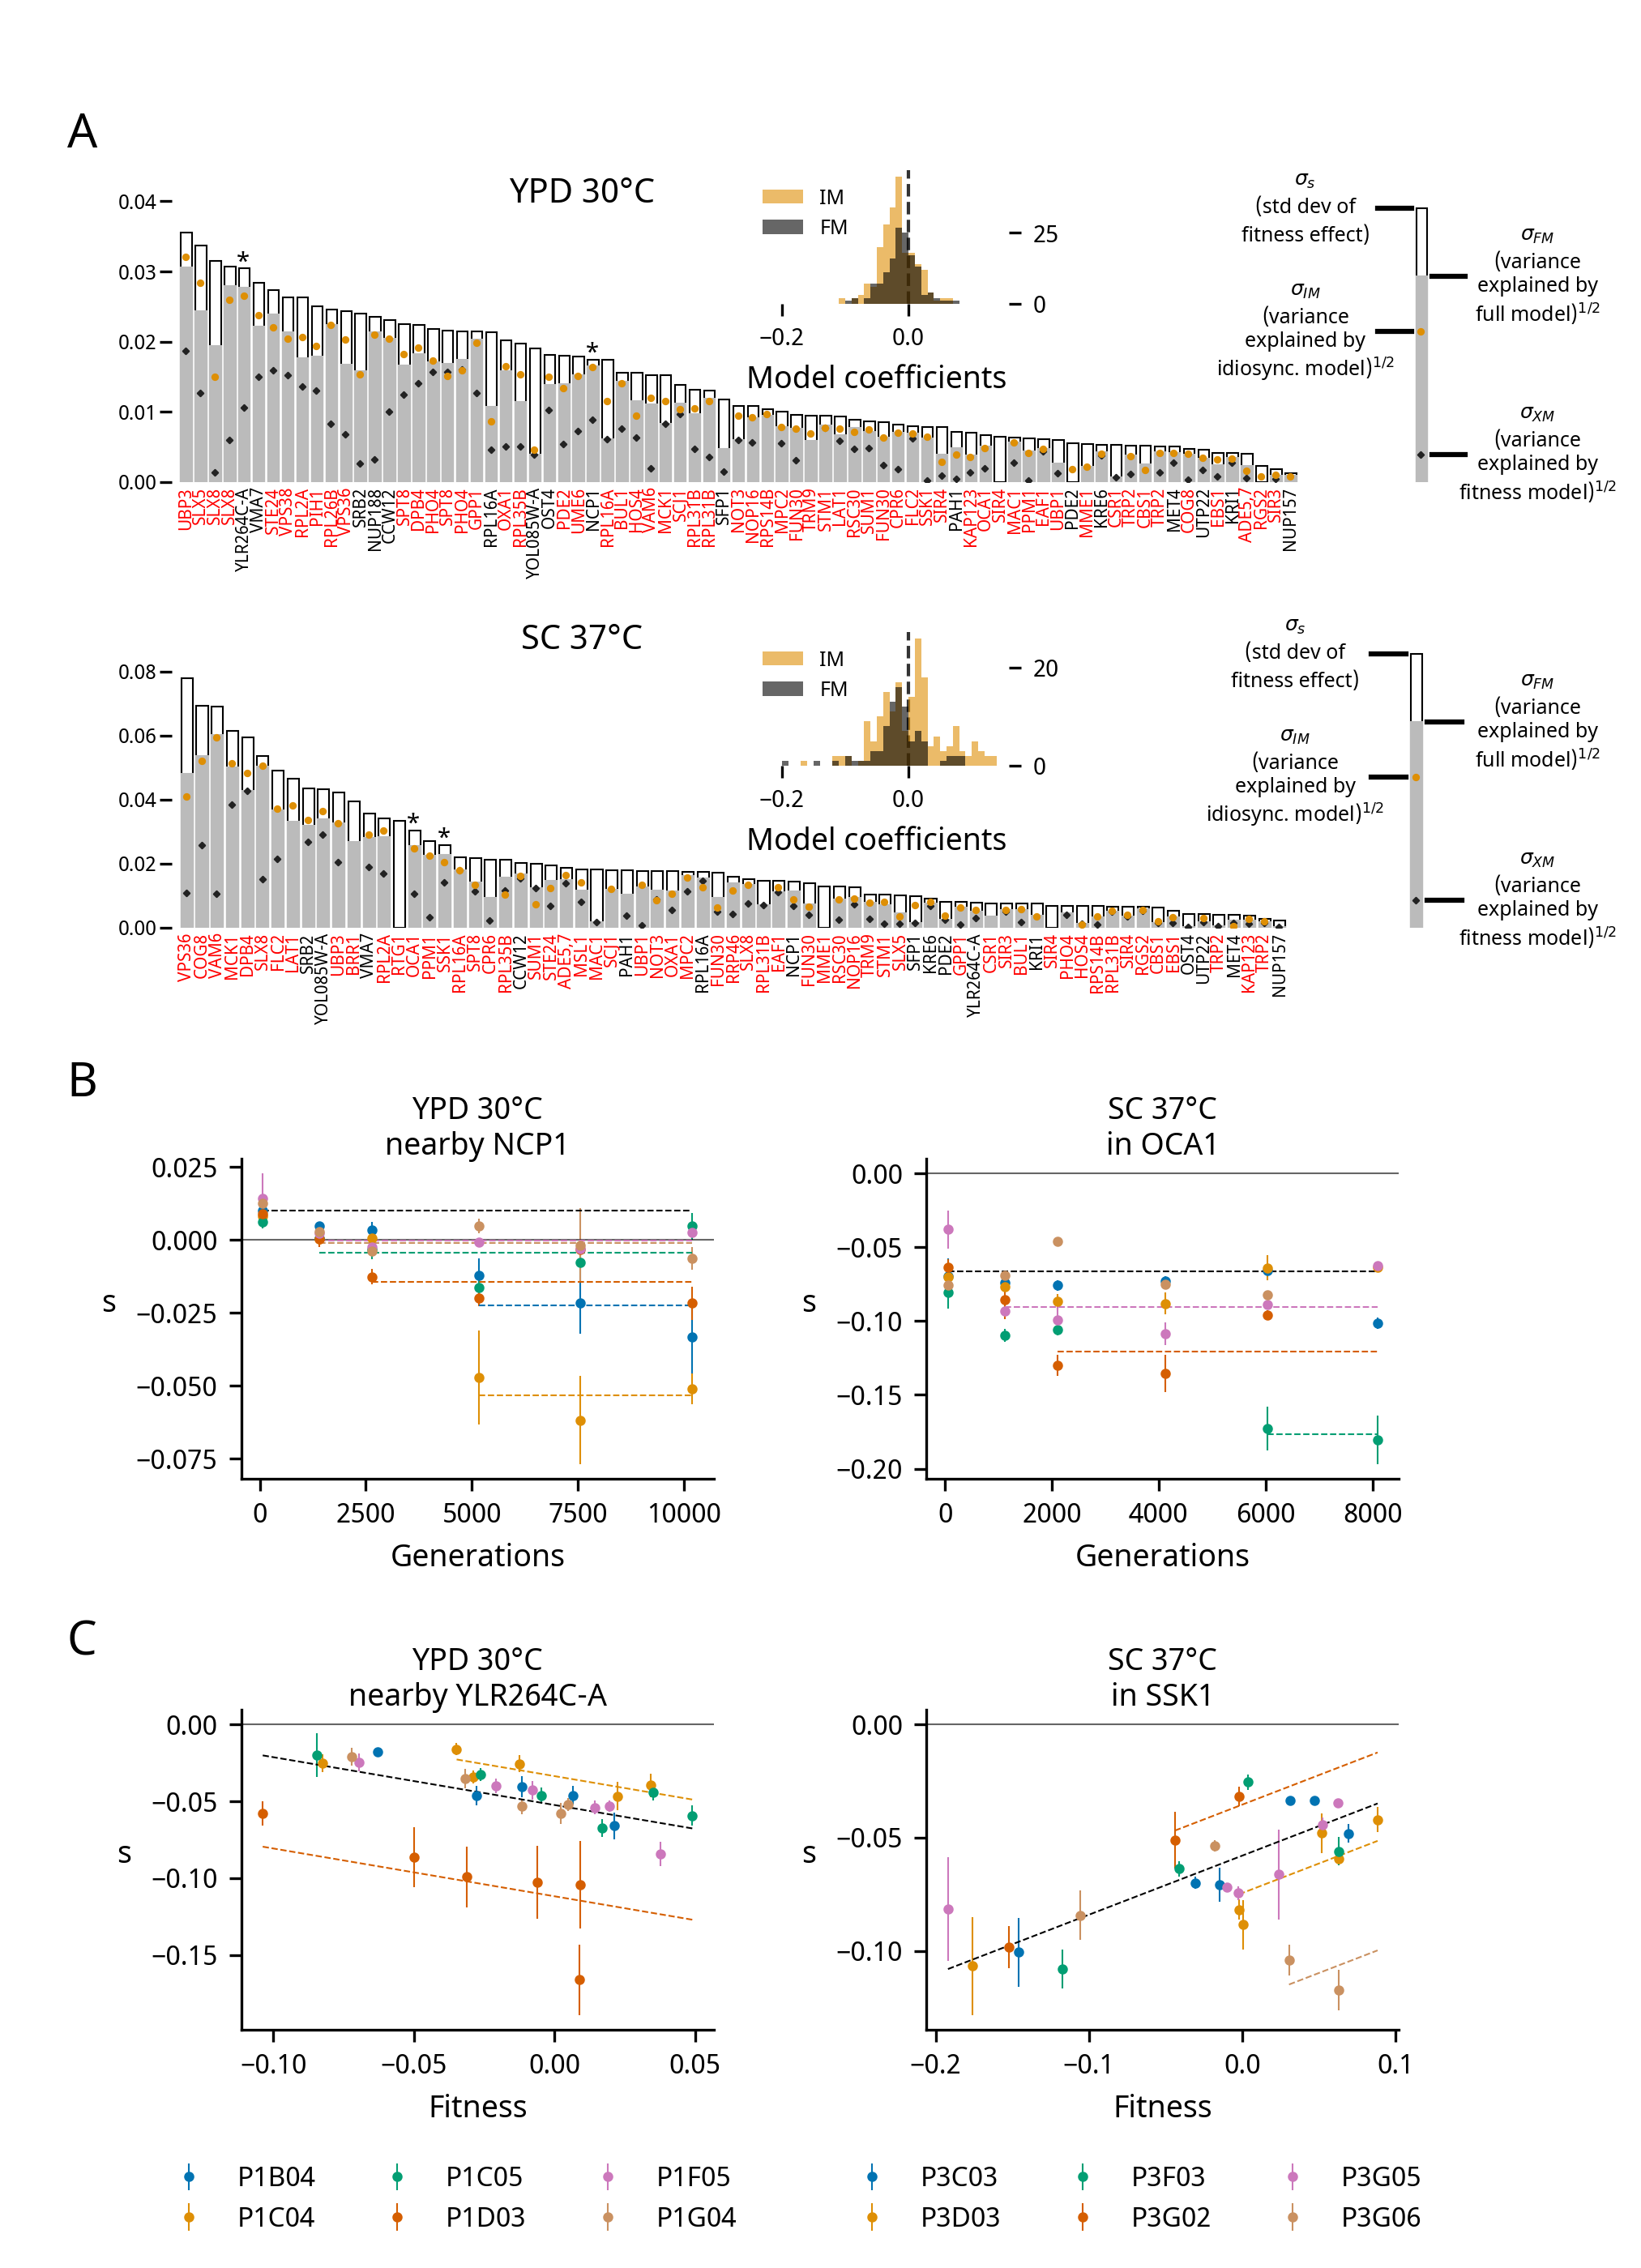

In [13]:
def determinant_plot(cond, top_sub, ex_edges, plot_example=True):

    df = edge_stats[(pd.notnull(edge_stats[cond+'_IM_Coeffs'])) & (edge_stats.Type=='Experiment')].sort_values(cond+'_s_var', ascending=False)
    print(len(df), 'edges')
    gene_descrips = list(df['Gene_Use'])
    edges_in_order = list(df['Edge'])
    example_loc = len(df)+8
    xbars = np.array([i for i in range(len(df))] + [example_loc])

    top_sub.tick_params(axis='y', which='major', labelsize=6, pad=1)
    top_sub.tick_params(axis='x', which='major', labelsize=4.5, pad=-2)
    top_sub.set_xlim([-1, len(gene_descrips)+16])
    mv = np.max(np.sqrt(df[cond+'_s_var']))*1.1
    ex_dev, ex_full, ex_qtl, ex_x = mv, mv*0.75, mv*0.55, mv*0.1
    if plot_example:
        top_sub.bar(xbars, list(np.sqrt(df[cond+'_s_var'])) + [ex_dev], color='none', edgecolor='black', lw=0.5, width=0.75)
        if cond != 'P3_YPD_30C': 
            top_sub.bar(xbars, list(np.sqrt(df[cond+'_FM_R2']*df[cond+'_s_var'])) + [ex_full], color='#BBBBBB', edgecolor='#BBBBBB', lw=0.5, width=0.75)
            top_sub.scatter(xbars-0.05, list(np.sqrt(df[cond+'_XM_R2']*df[cond+'_s_var'])) + [ex_x], color='#222222', marker='x', zorder=3, s=1.5)
        top_sub.scatter(xbars-0.05, list(np.sqrt(df[cond+'_IM_R2']*df[cond+'_s_var'])) + [ex_qtl], color=colors[1], marker='o', zorder=4, s=1.5)
    else:
        top_sub.bar(xbars[:-1], list(np.sqrt(df[cond+'_s_var'])), color='none', edgecolor='black', lw=0.5, width=0.75)
        if cond != 'P3_YPD_30C': 
            top_sub.bar(xbars[:-1], list(np.sqrt(df[cond+'_FM_R2']*df[cond+'_s_var'])), color='#BBBBBB', edgecolor='#BBBBBB', lw=0.5, width=0.75)
            top_sub.scatter(xbars[:-1]-0.05, list(np.sqrt(df[cond+'_XM_R2']*df[cond+'_s_var'])), color='#222222', marker='x', zorder=3, s=1.5)
        top_sub.scatter(xbars[:-1]-0.05, list(np.sqrt(df[cond+'_IM_R2']*df[cond+'_s_var'])), color=colors[1], marker='o', zorder=4, s=1.5)
    pl.axes(top_sub)
    pl.xticks(xbars, [i.split(' ')[1] for i in gene_descrips], rotation='vertical', fontsize=5)
    ticks = top_sub.get_xticklabels()
    cd = {'in': 'red', 'nearby': 'black'}
    jnk = [ticks[i].set_color(cd[gene_descrips[i].split(' ')[0]]) for i in range(len(gene_descrips))]
    if plot_example:
        if cond != 'P3_YPD_30C': 
            top_sub.annotate('$\sigma_{XM}$\n(variance\nexplained by\nfitness model)$^{1/2}$', xy=(example_loc+8, ex_x), xycoords='data', fontsize=6, ha='center', va='center')
            top_sub.plot([example_loc+0.7, example_loc+3], [ex_x, ex_x], c='k')
            top_sub.annotate("$\sigma_{FM}$\n(variance\nexplained by\nfull model)$^{1/2}$", xy=(example_loc+8, ex_full), xycoords='data', fontsize=6, ha='center', va='center')
            top_sub.plot([example_loc+0.7, example_loc+3], [ex_full, ex_full], c='k')
            
        top_sub.annotate('$\sigma_s$\n(std dev of\nfitness effect)', xy=(example_loc-8, ex_dev), xycoords='data', fontsize=6, ha='center', va='center')
        top_sub.plot([example_loc-0.7, example_loc-3], [ex_dev, ex_dev], c='k')
        top_sub.annotate('$\sigma_{IM}$\n(variance\nexplained by\nidiosync. model)$^{1/2}$', xy=(example_loc-8, ex_qtl), xycoords='data', fontsize=6, ha='center', va='center')
        top_sub.plot([example_loc-0.7, example_loc-3], [ex_qtl, ex_qtl], c='k')

        
    sns.despine(left=True, bottom=True)
    top_sub.tick_params(axis="x", bottom=False)
    
    for edge in ex_edges:
        top_sub.annotate('*', (edges_in_order.index(edge)-0.1, list(np.sqrt(df[cond+'_s_var']))[edges_in_order.index(edge)]), 
                         fontsize=7, zorder=5, horizontalalignment="center")
    
    coeffs = {'IM': [], 'FM': []}
    for edge in edges_in_order:
        if cond != 'P3_YPD_30C':
            fps = str(edge_stats[edge_stats.Edge==edge].iloc[0][cond+'_FM_Params']).split(';')
            FM_cs = str(edge_stats[edge_stats.Edge==edge].iloc[0][cond+'_FM_Coeffs']).split(';')
            coeffs['FM'] += [float(FM_cs[i]) for i in range(len(FM_cs)) if fps[i]!='Fitness_sub_70']
        coeffs['IM'] += [float(i) for i in str(edge_stats[edge_stats.Edge==edge].iloc[0][cond+'_IM_Coeffs']).split(';')][1:]
    return coeffs
        
def plot_hist(coeffs, sub, plot_FM=True):
    print(np.min(coeffs['IM']+coeffs['FM']), np.max(coeffs['IM']+coeffs['FM']))
    bin_lefts = [i*0.01-0.24 for i in range(39)]
    for model in coeffs:
        print(model, len(coeffs[model]), 'coeffs, mean', np.mean(coeffs[model]), ' std dev:', np.std(coeffs[model]))
    sub.hist(coeffs['IM'], bins=bin_lefts, zorder=1, alpha=0.6, color=colors[1], label='IM')
    if plot_FM:
        sub.hist(coeffs['FM'], bins=bin_lefts, zorder=1, alpha=0.6, color="k", label='FM')
    sub.axvline(0, zorder=0, color='#333', linestyle='dashed', lw=1)
    sub.set_xlabel('Model coefficients', fontsize=9)
    #sub.set_ylim([0,top])
    #sub.set_yticks([0,20])
    sub.legend(frameon=False, fontsize=6)
    sub.yaxis.tick_right()
    sub.tick_params(which='both', labelsize=7)
    sns.despine(ax=sub, bottom=True, left=True)

def plot_one_det(sub, cond, edge, model, axis_color, title_cond=True, ms=2, xlabel=True, title_at_all=True, ls=7):
    td = vtn_s[(vtn_s['Edge']==edge) & (vtn_s['Cond']==cond) & (vtn_s['num_cbcs']>=5)]
    sub.axhline(0, color='k', linewidth=0.5, alpha=0.6)
    xvar = {'FM': 'Fitness', 'IM': 'Gen', 'IM2': 'Gen'}[model]
    for pop in cond_pops[cond.split('_')[0]]:
        ttd = td[td.Pop==pop].sort_values('Gen')
        if xvar == 'Gen':
            gen_rec = [gen_fixer[g][cond.split('_')[0]] for g in ttd['Gen']]
            sub.errorbar(x=gen_rec, y=ttd['s'], yerr=ttd['stderr'], linestyle='', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
        else:
            sub.errorbar(x=ttd[xvar], y=ttd['s'], yerr=ttd['stderr'], linestyle='', marker='.', markersize=ms, linewidth=0.5, color=color_map[pop], label=pop)
    if xlabel: 
        sub.set_xlabel({'Gen': 'Generations', 'Fitness': 'Fitness'}[xvar], fontsize=ls)
    gene = edge_stats[edge_stats.Edge==edge].iloc[0]['Gene_Use']
    if title_cond:
        sub.set_title(cond_to_title[cond] + '\n' + gene, fontsize=ls, y=0.95)
    elif title_at_all:
        sub.set_title(gene, fontsize=ls, y=0.95)
    
    #sub.set_ylim([-0.15, 0.1])
    sub.tick_params(which='both', labelsize=6, colors=axis_color)
    sub.spines['bottom'].set_color(axis_color)
    sub.spines['left'].set_color(axis_color)
    #fit lines
    fit = edge_stats[edge_stats.Edge==edge].iloc[0]
    if pd.notnull(fit[cond+'_'+model+'_Params']):
        params = fit[cond+'_'+model+'_Params'].split(';')
        cs = fit[cond+'_'+model+'_Coeffs'].split(';')
        coeffs = {params[i]: float(cs[i]) for i in range(len(params))}
        if model == 'IM': 
            coeffs['Fitness_sub_70'] = 0
            coeffs['Intercept'] = td['g70_s'].iloc[0]
        elif model == 'FM':
            coeffs['Intercept'] = td['g70_s'].iloc[0]-g70_fits[cond]*coeffs['Fitness_sub_70']
        if xvar == 'Gen':
            x_rec = [gen_fixer[g][cond.split('_')[0]] for g in td['Gen']]
        else:
            x_rec = td[xvar]
        xlims = [np.min(x_rec), np.max(x_rec)]
        sub.plot(xlims, [i*coeffs['Fitness_sub_70']+coeffs['Intercept'] for i in xlims], c='k', linestyle='dashed', lw=0.5)
        for coef in [c for c in coeffs if c not in ['Fitness_sub_70', 'Intercept', 'dummy']]:
            if xvar == 'Gen':
                xlims[0] = np.min([gen_fixer[g][cond.split('_')[0]] for g in td[(td['Pop']==coef.split('_')[1]) & (td['Gen']>=int(coef.split('_')[-1]))][xvar]])
            else:
                xlims[0] = np.min(td[(td['Pop']==coef.split('_')[1]) & (td['Gen']>=int(coef.split('_')[-1]))][xvar])
            sub.plot(xlims, [i*coeffs['Fitness_sub_70']+coeffs['Intercept']+coeffs[coef] for i in xlims], c=color_map[coef.split('_')[1]], linestyle='dashed', lw=0.5)


###
### NOTE TO SELF: I think it would be better to have two histograms rather than the overlap
###

ypd_examples = [
    #'GAGTGCTTCAAAGTT', # RPS14B
    'TAACCTCGCGCTGAG', # nearby NCP1
    'ATATTGAGTAAGTAC', # YLR-264C-A
    #'AGTTTATAAAAAATT', # nearby CCW12
]
sc_examples = [
    #'CATTTATGGCTATCT', # VAM6
    'AGAAGACGACGATGA', # OCA1
    #'TTTTGCATTTAGGCG', # MPC2
    'CCAGGATGTACCGCC', # SSK1
]

fig = pl.figure(figsize=(7.25, 10), dpi=300)
gs0 = gridspec.GridSpec(27, 20)
top_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[:11,:])
subs = [pl.Subplot(fig, top_gs[i]) for i in range(2)] 
jnk = [fig.add_subplot(s) for s in subs]   
pl.subplots_adjust(hspace=0.55, wspace=0.45)
coeff_list = determinant_plot('P1_YPD_30C', subs[0], ypd_examples)
subs[0].set_title('YPD 30°C', fontsize=10, x=0.3, y=0.9)
subs[1].set_title('SC 37°C', fontsize=10, x=0.3, y=0.9)
isub1 = fig.add_axes([0.45, 0.835, 0.15, 0.055])
print('YPD')
plot_hist(coeff_list, isub1)
#plot_heatmap(mat, sub, 'YPD 30°C')
coeff_list = determinant_plot('P3_SC_37C', subs[1], sc_examples)
isub2 = fig.add_axes([0.45, 0.645, 0.15, 0.055])
print('SC')
plot_hist(coeff_list, isub2)
#plot_heatmap(mat, sub, 'SC 37°C')

tmp_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[14:19,1:18])
subs0 = [pl.Subplot(fig, tmp_gs[j]) for j in range(2)]
jnk = [fig.add_subplot(subs0[j]) for j in range(2)]
tmp_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[22:,1:18])
subs1 = [pl.Subplot(fig, tmp_gs[j]) for j in range(2)]
jnk = [fig.add_subplot(subs1[j]) for j in range(2)]
#pl.subplots_adjust(hspace=0.8, wspace=0.4)

plot_one_det(subs0[0], 'P1_YPD_30C', 'TAACCTCGCGCTGAG', 'IM', 'k', ms=4, ls=9)
plot_one_det(subs0[1], 'P3_SC_37C', 'AGAAGACGACGATGA', 'IM', 'k', ms=4, ls=9)
plot_one_det(subs1[0], 'P1_YPD_30C', 'ATATTGAGTAAGTAC', 'FM', 'k', ms=4, ls=9) 
plot_one_det(subs1[1], 'P3_SC_37C', 'CCAGGATGTACCGCC', 'FM', 'k', ms=4, ls=9)



for j in range(2):
    subs0[j].set_ylabel('s', rotation='horizontal', fontsize=9, labelpad=8)
    subs1[j].set_ylabel('s', rotation='horizontal', fontsize=9, labelpad=8)
    subs0[j].tick_params(which='both', labelsize=8)
    subs1[j].tick_params(which='both', labelsize=8)
    sns.despine(ax=subs0[j])
    sns.despine(ax=subs1[j])
    subs1[j].legend(frameon=False, bbox_to_anchor=(1.1,-0.35), ncol=3, fontsize=8)

pl.annotate('A', fontsize=14, xy=(0.05, 0.935), xycoords="figure fraction", horizontalalignment="center")
pl.annotate('B', fontsize=14, xy=(0.05, (27-14)/27+0.035), xycoords="figure fraction", horizontalalignment="center")
pl.annotate('C', fontsize=14, xy=(0.05, (27-22)/27+0.085), xycoords="figure fraction", horizontalalignment="center")

fig.savefig('../../Figures/Determinants.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)


70 edges


/n/home13/mjohnson/anaconda3/envs/milo_py37/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/n/home13/mjohnson/anaconda3/envs/milo_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-0.22346404853287868 0.14681966639900348
IM 171 coeffs, mean -0.008803900458382911  std dev: 0.05879129940219829
FM 199 coeffs, mean -0.011562093544588174  std dev: 0.06435858835033176


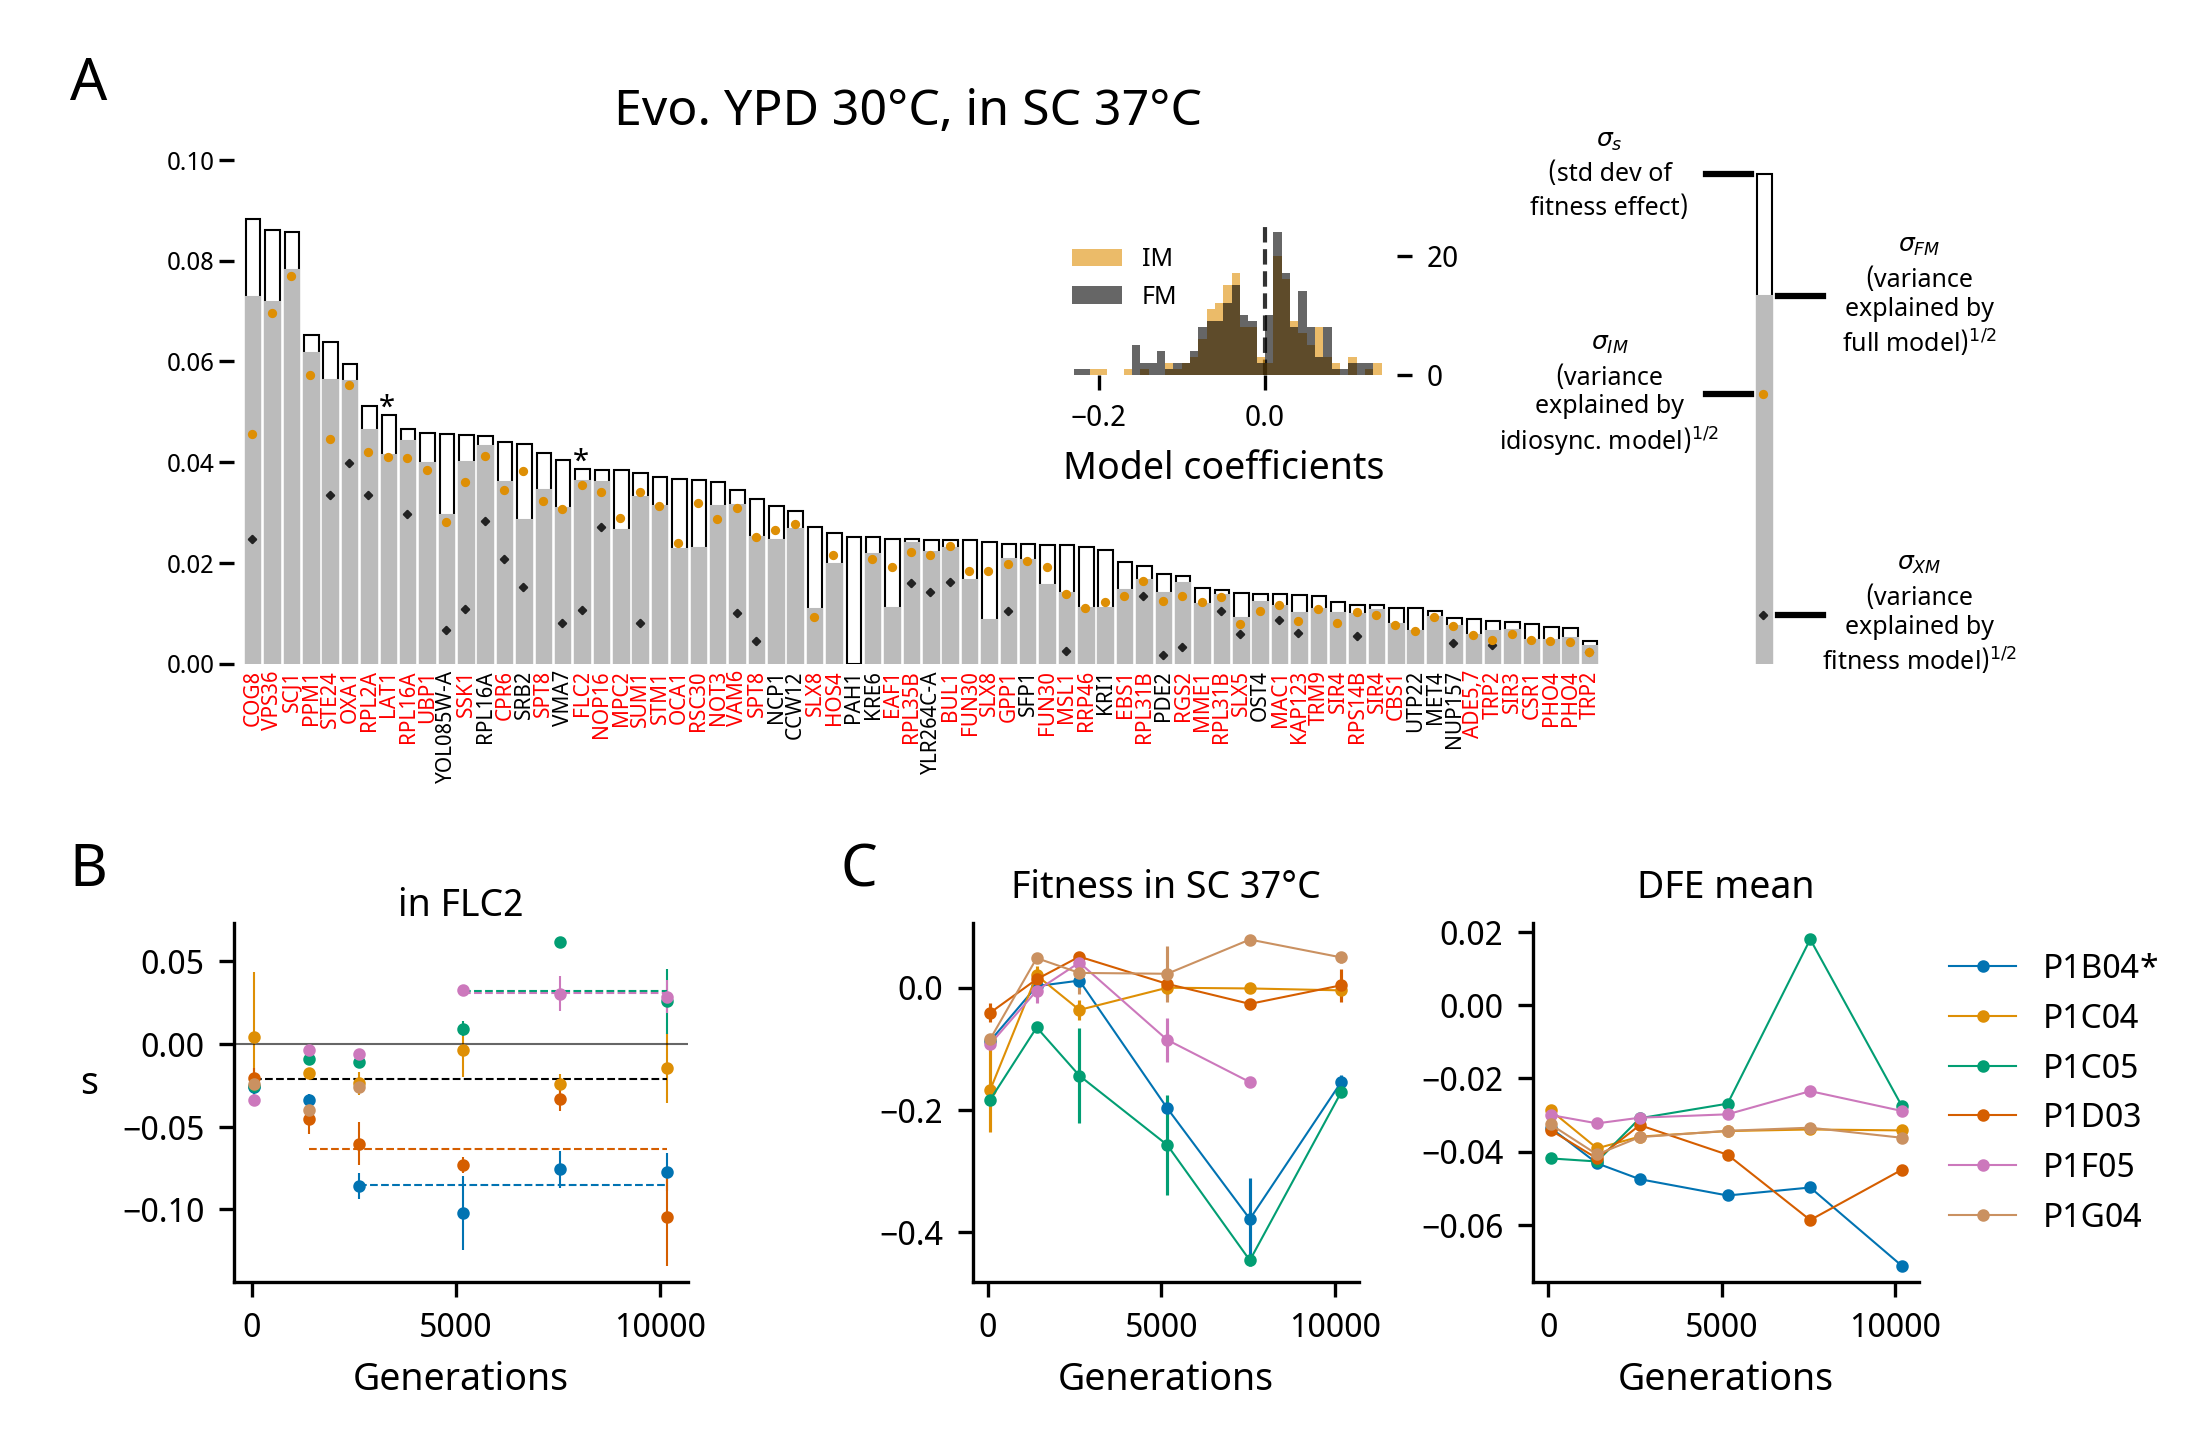

In [14]:
p1_sc_examples = [
    'CTAAGCAGTCTTCTC', # in_LAT1_
    'TGATCATCACGGGAC', # in_FLC2_
    #'TTTAACTCACCGTAA', # nearby_SFP1_
]

fig = pl.figure(figsize=(7.25, 5), dpi=300)
gs0 = gridspec.GridSpec(15, 14)
top_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[:7,:])
sub = pl.Subplot(fig, top_gs[0])
fig.add_subplot(sub)  


coeff_list = determinant_plot('P1_SC_37C', sub, p1_sc_examples)
sub.set_title(cond_to_title['P1_SC_37C'], fontsize=12, x=0.4, y=1)
isub1 = fig.add_axes([0.5, 0.73, 0.16, 0.1])
plot_hist(coeff_list, isub1)
#plot_heatmap(mat, sub, 'YPD 30°C')

dfe_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[10:,6:])
dfe_subs = [pl.Subplot(fig, dfe_gs[0]), pl.Subplot(fig, dfe_gs[1])]
jnk = [fig.add_subplot(dfe_subs[i]) for i in range(2)]  
cond = 'P1_SC_37C'
td = vtn_dfe[vtn_dfe.Cond==cond]
for pop in cond_pops[cond.split('_')[0]]:
    ttd = td[td.Pop==pop].sort_values('Gen')
    gen_rec = [gen_fixer[g][cond.split('_')[0]] for g in ttd['Gen']]
    if sci_stats.linregress(gen_rec, ttd['DFE_mean'])[3]<0.05:
        lab = pop+'*'
    else:
        lab = pop
    #if len(ttd[ttd['Fitness_std']==0]) > 0:
    #    print('Missing errors for', cond, pop, list(ttd[ttd['Fitness_std']==0]['Gen']))
    dfe_subs[0].errorbar(x=gen_rec, y=ttd['Fitness'], yerr=ttd['Fitness_std'], linestyle='-', marker='.', markersize=4, elinewidth=0.75, linewidth=0.5, color=color_map[pop], label=lab)
    dfe_subs[1].plot(gen_rec, ttd['DFE_mean'], linestyle='-', marker='.', markersize=4, linewidth=0.5, color=color_map[pop], label=lab)
dfe_subs[1].set_title('DFE mean', fontsize=9)
dfe_subs[0].set_title('Fitness in SC 37°C', fontsize=9)
dfe_subs[1].legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=8)
for dfe_sub in dfe_subs:
    dfe_sub.tick_params(labelsize=8)
    dfe_sub.set_xlabel('Generations', fontsize=9)
    sns.despine(ax=dfe_sub)


tmp_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[10:,:4])
subs0 = [pl.Subplot(fig, tmp_gs[j]) for j in range(1)]
jnk = [fig.add_subplot(subs0[j]) for j in range(1)]
pl.subplots_adjust(hspace=0.55, wspace=0.45)
#plot_one_det(subs0[0], 'P1_SC_37C', 'CTAAGCAGTCTTCTC', 'IM', 'k', title_cond=False)
plot_one_det(subs0[0], 'P1_SC_37C', 'TGATCATCACGGGAC', 'IM', 'k', title_cond=False, ms=4, ls=9) 
#plot_one_det(subs0[2], 'P1_SC_37C', 'TTTAACTCACCGTAA', 'IM', 'k', title_cond=False) 

subs0[0].set_ylabel('s', rotation='horizontal', fontsize=9, labelpad=8)
jnk = [sns.despine(ax=subs0[j]) for j in range(1)]
subs0[0].tick_params(which='both', labelsize=8)
sns.despine(ax=subs0[0])

pl.annotate('A', fontsize=14, xy=(0.04, 0.93), xycoords="figure fraction", horizontalalignment="center")
pl.annotate('B', fontsize=14, xy=(0.04, 0.38), xycoords="figure fraction", horizontalalignment="center")
pl.annotate('C', fontsize=14, xy=(0.39, 0.38), xycoords="figure fraction", horizontalalignment="center")

fig.savefig('../../Figures/P1_SC_37C_all.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)
